## Research design 

Focusing on subjects with Parkinson's Disease and healthy controls, we aim to develop a progression index that maps ambulatory activity as a function of time. As time increases, the index maximizes the distance between the two cohorts' averages. 

#### Step 1: 
Import the necessary libraries 

In [97]:
import torch
# torch.nn is a module that contains all the neural network layers
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

#### Step 2: 

Prepare the data for training.

In [109]:
def prepare_sequences(df, sequence_length=3):
    """
    Prepare sequences of activity data for the LSTM model by producing sliding windows of activity data of length `sequence_length`.

    Args:
    df (pd.DataFrame): DataFrame containing the activity data with columns ['subject', 'week_num', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'].
    sequence_length (int): The length of the sequences to create.

    Returns:
    tuple: A tuple containing:
        - torch.FloatTensor: Sequences of activity data of shape (num_samples, sequence_length, num_features=7).
        - torch.FloatTensor: Current week data of shape (num_samples, num_features=7).
        - torch.LongTensor: Labels indicating the cohort (1 for PD, 0 for HC).
        - list: A list of tuples (subject, week_num) for each sequence.
    """
    sequences = []
    current_weeks = []  # This will hold the week data immediately after each sequence
    labels = []
    subject_weeks = []
    
    for subject in df['subject'].unique():
        subject_data = df[df['subject'] == subject].sort_values('week_num')
        
        # Skip subjects with too few weeks
        if len(subject_data) < sequence_length + 1:
            continue
            
        # Get activity data
        activity_data = subject_data[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].values
        
        # Create sequences
        for i in range(len(activity_data) - sequence_length):
            # window of consecutive weeks of data 
            seq = activity_data[i:i+sequence_length]
            # the week immediately after the sequence
            current_week = activity_data[i+sequence_length]  
            
            sequences.append(seq)
            current_weeks.append(current_week)
            labels.append(1 if subject_data['cohort'].iloc[0] == 'PD' else 0)
            subject_weeks.append((subject, subject_data['week_num'].iloc[i+sequence_length]))
    
    # need tensors for torch
    return (torch.FloatTensor(sequences),
            torch.FloatTensor(current_weeks),
            torch.LongTensor(labels), 
            subject_weeks)

In [ ]:
# print the shape of the output tensors 
print(prepare_sequences(df, sequence_length=3)[0].shape)

# n_seq, batch size, n_features where n_seq is the number of weeks, batch size is the number of samples, and n_features is the number of features in the data.
# pad with 0s 
# but for now, take like 20 weeks so that we can have consistent number of weeks for all subjects 

torch.Size([15198, 3, 7])


#### Step 3:

Define the LSTM model. 

In [ ]:
class ActivityLSTM(nn.Module):

    """
    This ActivityLSTM class defines the LSTM model for activity recognition and inherits from nn.Module.
    """

    # __init__ is the constructor function
    def __init__(self, input_dim=7, hidden_dim=16, num_layers=1):
        """
        The constructor initializes the LSTM layer and the fully connected layer (linear layer).
        The LSTM layer processes the input sequence data, and the linear layer maps the output of the LSTM to the desired output dimension.

        Args: 
        input_dim: int, number of input features
        hidden_dim: int, number of hidden units in the LSTM layer
        num_layers: int, number of LSTM layers
        """
        super(ActivityLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, input_dim) # output dimension is same as input dimension

        # ReLU and softmax to impose constraints on the output weights f 
        # f must be non-negative and sum to 1
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        The forward function defines the forward pass of the model.
        It takes the input tensor x, processes it through the LSTM layer, 
        and then through the linear layer to produce the output weights.

        Args:
        x: torch.Tensor, input tensor of shape (batch_size, seq_len, input_dim)

        Returns:
        torch.Tensor, output weights of shape (batch_size, input_dim)
        """
        # hidden states and cell states are by default initialized to zero

        # lstm_out is the output of the LSTM layer
        lstm_out, _ = self.lstm(x)

        # take the output from the last time step
        last_output = lstm_out[:, -1, :]

        # get weights through linear layer
        weights = self.linear(last_output)

        # ReLU and softmax
        weights = self.relu(weights)
        weights = self.softmax(weights)

        # Custom normalization instead of softmax
        #epsilon = 1e-10  # small value to prevent division by zero
        #sum_weights = torch.sum(weights, dim=1, keepdim=True) + epsilon
        #weights = weights / sum_weights

        return weights

#### Step 4:
Define the loss function and optimizer.

In [104]:
def train_model(model, train_sequences, current_weeks, labels, subject_weeks, num_epochs, lr=0.001, gamma_factor=1):
    """
    Trains the LSTM model to maximize the separation between PD and HC cohorts.
    
    Args:
    - model (torch.nn.Module): The LSTM model to be trained.
    - train_sequences (torch.Tensor): Tensor of sequence data (batch_size, seq_len, input_dim)
    - current_weeks (torch.Tensor): Tensor of the current week data (batch_size, input_dim)
    - labels (torch.Tensor): Tensor of cohort labels (1 for PD, 0 for HC)
    - subject_weeks (list): List of (subject, week_num) tuples for time weighting
    - num_epochs (int): The number of epochs for training.
    - lr (float): Learning rate for the optimizer. Default is 0.001.
    - gamma_factor (float): Scaling factor for gamma(t) in the loss function. Default is 1.
    
    Returns:
    - model (torch.nn.Module): The trained LSTM model.
    - loss_history (list): List of training losses for each epoch.
    """
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # initalize history 
    history = {
        'loss': [],
        'pd_mean': [],
        'hc_mean': [],
        'separation': []
    }
    
    # Extract week numbers for time weighting
    week_nums = torch.tensor([week for _, week in subject_weeks], dtype=torch.float32)
    
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        
        # Forward pass
        weights = model(train_sequences)
        
        # Compute the index u_i(t) = X_i^T(t) * f(...)
        # Element-wise multiply weights with current week data and sum across days
        indices = torch.sum(current_weeks * weights, dim=1)
        
        # Separate indices for PD and HC cohorts
        pd_mask = (labels == 1)
        hc_mask = (labels == 0)
        
        if pd_mask.sum() > 0 and hc_mask.sum() > 0:
            pd_indices = indices[pd_mask]
            hc_indices = indices[hc_mask]
            
            # Compute means for each cohort
            pd_mean = pd_indices.mean()
            hc_mean = hc_indices.mean()
            
            # Compute the separation between cohorts
            separation = pd_mean - hc_mean
            history['pd_mean'].append(pd_mean.item())
            history['hc_mean'].append(hc_mean.item())
            history['separation'].append(separation.item())

            # Time weighting factor
            gamma_t = 1 + (epoch * gamma_factor)
            
            # Compute the loss (negative since we want to maximize the difference)
            loss = -gamma_t * (pd_mean - hc_mean)
            history['loss'].append(loss.item())
            
            # Add regularization if needed
            # loss += some_regularization_term
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Skipping (no data for one cohort)')
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['pd_mean'], label='PD')
    plt.plot(history['hc_mean'], label='HC')
    plt.plot(history['separation'], label='Separation')
    plt.title('Group Means')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return model, loss_history


In [ ]:
def train_model(model, train_data, learning_rate=0.001, num_epochs=500):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        # total_loss to accumulate loss over the epoch, initialized to 0
        total_loss = 0
        
        for batch_idx, batch in enumerate(train_data):
            optimizer.zero_grad()
            
            # Get model weights
            weights = model(batch)
            
            # Calculate u_i(t) scores!
            # X_i(t)
            current_week = batch[:, -1, :]  # shape: (batch_size, 7)
            # u_i(t) = X_i(t) * f
            u_scores = torch.sum(current_week * weights, dim=1)

            # Calculate the time weights gamma 
            gamma_t = 1 + batch_idx 
            
            # Calculate loss (maximizing PD-HC difference)
            pd_scores = u_scores[pd_indices]
            hc_scores = u_scores[hc_indices]
            loss = -gamma_t * torch.mean(pd_scores - hc_scores)  # negative because we want to maximize
            
            # Backpropagate
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        print(f'Epoch {epoch}, Loss: {total_loss}, Gamma_t: {gamma_t}, batch_idx: {batch_idx}')
        

### Step 5: 
Evaluate and plot predictions.

In [102]:
def evaluate_and_plot(model, test_sequences, test_current_weeks, test_labels, subject_weeks):
    """
    Evaluates the trained model on test data and creates visualizations.
    
    Args:
    - model (torch.nn.Module): The trained LSTM model
    - test_sequences (torch.Tensor): Tensor of sequence data (batch_size, seq_len, input_dim)
    - test_current_weeks (torch.Tensor): Tensor of the current week data (batch_size, input_dim)
    - test_labels (torch.Tensor): Tensor of cohort labels (1 for PD, 0 for HC)
    - subject_weeks (list): List of (subject, week_num) tuples for reference
    
    Returns:
    - dict: A dictionary containing evaluation metrics
    """
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Get model weights
        weights = model(test_sequences)
        
        # Compute indices
        indices = torch.sum(test_current_weeks * weights, dim=1).numpy()
        
        # Create a dataframe for easier analysis
        results_df = pd.DataFrame({
            'Subject': [s for s, _ in subject_weeks],
            'Week': [w for _, w in subject_weeks],
            'Index': indices,
            'Cohort': ['PD' if label == 1 else 'HC' for label in test_labels.numpy()]
        })
        
        # Calculate statistics
        pd_indices = indices[test_labels.numpy() == 1]
        hc_indices = indices[test_labels.numpy() == 0]
        
        pd_mean = np.mean(pd_indices)
        hc_mean = np.mean(hc_indices)
        
        pd_std = np.std(pd_indices)
        hc_std = np.std(hc_indices)
        
        cohort_diff = pd_mean - hc_mean
        
        metrics = {
            'pd_mean': pd_mean,
            'hc_mean': hc_mean,
            'pd_std': pd_std,
            'hc_std': hc_std,
            'cohort_diff': cohort_diff
        }
        
        # Create plots
        plt.figure(figsize=(15, 10))
        
        # 1. Distribution of indices by cohort
        plt.subplot(2, 2, 1)
        sns.histplot(data=results_df, x='Index', hue='Cohort', kde=True, bins=20)
        plt.title(f'Distribution of Activity Indices by Cohort\nDifference: {cohort_diff:.4f}')
        plt.xlabel('Activity Index')
        plt.ylabel('Count')
        
        # 2. Box plot of indices by cohort
        plt.subplot(2, 2, 2)
        sns.boxplot(data=results_df, x='Cohort', y='Index')
        plt.title('Box Plot of Activity Indices by Cohort')
        plt.ylabel('Activity Index')
        
        # 3. Subject-wise average indices
        plt.subplot(2, 2, 3)
        subject_avg = results_df.groupby(['Subject', 'Cohort'])['Index'].mean().reset_index()
        sns.barplot(data=subject_avg, x='Subject', y='Index', hue='Cohort')
        plt.title('Average Activity Index by Subject')
        plt.xticks(rotation=90)
        plt.xlabel('Subject ID')
        plt.ylabel('Average Activity Index')
        
        # 4. ROC Curve for binary classification
        plt.subplot(2, 2, 4)
        fpr, tpr, _ = roc_curve(test_labels.numpy(), indices)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        
        plt.tight_layout()
        
        # 5. Create a separate figure for time series plot
        plt.figure(figsize=(15, 6))
        
        # Sort by subject and week to maintain time order
        ts_df = results_df.sort_values(['Subject', 'Week'])
        
        # Plot time series for each subject
        for subject in ts_df['Subject'].unique():
            sub_data = ts_df[ts_df['Subject'] == subject]
            cohort = sub_data['Cohort'].iloc[0]
            color = 'red' if cohort == 'PD' else 'blue'
            plt.plot(sub_data['Week'], sub_data['Index'], 
                    marker='o', linestyle='-', alpha=0.7, color=color,
                    label=f"{subject} ({cohort})" if subject == ts_df['Subject'].unique()[0] else "")
        
        # Add cohort-specific legend entries
        plt.plot([], [], color='red', label='PD')
        plt.plot([], [], color='blue', label='HC')
        
        plt.title('Activity Index Time Series by Subject')
        plt.xlabel('Week')
        plt.ylabel('Activity Index')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
        # Additional analysis: LSTM weights distribution
        plt.figure(figsize=(10, 6))
        weight_df = pd.DataFrame(weights.numpy(), columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        
        # Melt the dataframe for easier plotting
        weight_df_melted = pd.melt(weight_df, var_name='Day', value_name='Weight')
        
        # Boxplot of weight

In [84]:
def train_and_evaluate(df, sequence_length=3, num_epochs=2):
    # Prepare data
    sequences, labels, subject_weeks = prepare_sequences(df, sequence_length)
    
    if len(sequences) == 0:
        print("No valid sequences found! Check data or reduce sequence_length.")
        return None
        
    print(f"Created {len(sequences)} sequences from {df['subject'].nunique()} subjects")
    
    # Create model
    model = ActivityLSTM()
    optimizer = torch.optim.Adam(model.parameters())
    
    # Training history
    history = {
        'loss': [],
        'pd_mean': [],
        'hc_mean': [],
        'separation': []
    }
    
    # Train
    for epoch in range(num_epochs):
        model.train()
        
        # Get model weights
        weights = model(sequences)
        
        # Calculate u_i(t) scores
        current_week = sequences[:, -1, :]  # last week in sequence
        u_scores = torch.sum(current_week * weights, dim=1)
        
        # Split scores by group
        pd_indices = (labels == 1)
        hc_indices = (labels == 0)
        
        pd_scores = u_scores[pd_indices]
        hc_scores = u_scores[hc_indices]
        
        # Check if we have both groups
        if len(pd_scores) == 0 or len(hc_scores) == 0:
            print("Warning: Missing one group in the data!")
            continue
        
        # Calculate weighted loss with gamma(t)
        gamma_t = (1 + epoch) / 51 # divide by 51 for now so that gamma doesn't explode
        loss = -gamma_t * (torch.mean(pd_scores) - torch.mean(hc_scores))
        
        # Backpropagate
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        # Record history
        history['loss'].append(loss.item())
        history['pd_mean'].append(torch.mean(pd_scores).item())
        history['hc_mean'].append(torch.mean(hc_scores).item()) 
        history['separation'].append(torch.mean(hc_scores).item() - torch.mean(pd_scores).item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}, gamma_t: {gamma_t:.4f}, batch_idx: {len(sequences)}')
            print(f'PD mean: {torch.mean(pd_scores):.4f}, HC mean: {torch.mean(hc_scores):.4f}')
            
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['pd_mean'], label='PD')
    plt.plot(history['hc_mean'], label='HC')
    plt.plot(history['separation'], label='Separation')
    plt.title('Group Means')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, history, (sequences, labels, subject_weeks)

In [56]:
def run_subset_analysis(df, num_subjects=10, min_weeks=5):
    # Filter to subjects with enough data
    subject_week_counts = df.groupby('subject').size()
    valid_subjects = subject_week_counts[subject_week_counts >= min_weeks].index.tolist()
    
    # Take a subset
    if len(valid_subjects) > num_subjects:
        pd_subjects = df[df['cohort'] == 'PD']['subject'].unique()
        control_subjects = df[df['cohort'] == 'Control']['subject'].unique()
        
        # Try to balance PD and control subjects
        pd_to_use = min(len(pd_subjects), num_subjects//2)
        control_to_use = min(len(control_subjects), num_subjects - pd_to_use)
        
        selected_subjects = list(pd_subjects[:pd_to_use]) + list(control_subjects[:control_to_use])
        selected_subjects = [s for s in selected_subjects if s in valid_subjects]
    else:
        selected_subjects = valid_subjects
    
    # Create subset
    subset_df = df[df['subject'].isin(selected_subjects)]
    print(f"Selected {len(selected_subjects)} subjects with {len(subset_df)} total weeks")
    
    # Train model
    return train_and_evaluate(subset_df, sequence_length=3)

## test run with a subset of subjects 

In [ ]:
# load data
df = pd.read_csv('ModelData.csv')
# head the data 
print(df.head())

# print uniqeu values for cohort 
print(df['cohort'].unique())
# need to fix so that we are only considering PD and HC

   subject   Mon   Tue   Wed   Thu   Fri   Sat   Sun  missing_count  \
0     3003   5.0  32.0  15.0  41.0  37.0  26.0  39.0              6   
1     3003  57.0  48.0  86.0  37.0  22.0  59.0  17.0              3   
2     3003  26.0  25.0  60.0  43.0  13.0  36.0  14.0              0   
3     3003  40.0  39.0  37.0  18.0  66.0  52.0  13.0              0   
4     3003  48.0  54.0  18.0  60.0  63.0  54.0  32.0              0   

   Mon_deviation_lag  ...  Fri_deviation_lag  Sat_deviation_lag  \
0          -0.401253  ...           0.210877          -0.390146   
1          -1.659728  ...           0.210877          -0.390146   
2           1.185520  ...          -0.637180           1.380079   
3          -0.510685  ...          -1.146013           0.146286   
4           0.255343  ...           1.850453           1.004577   

   Sun_deviation_lag  anomaly_count  cohort  year  week_num  season  \
0           0.880135              0      PD  2019        15  Spring   
1           0.880135        

In [59]:
# only keep the columns we need
# subject, Mon:Sun, cohort, week_num
df1 = df[['subject', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'cohort', 'week_num']]
print(df1.head())

   subject   Mon   Tue   Wed   Thu   Fri   Sat   Sun cohort  week_num
0     3003   5.0  32.0  15.0  41.0  37.0  26.0  39.0     PD        15
1     3003  57.0  48.0  86.0  37.0  22.0  59.0  17.0     PD        17
2     3003  26.0  25.0  60.0  43.0  13.0  36.0  14.0     PD        18
3     3003  40.0  39.0  37.0  18.0  66.0  52.0  13.0     PD        19
4     3003  48.0  54.0  18.0  60.0  63.0  54.0  32.0     PD        20


Epoch [1/50], Loss: 22.6595
Epoch [2/50], Loss: 45.3064
Epoch [3/50], Loss: 67.9440
Epoch [4/50], Loss: 90.5735
Epoch [5/50], Loss: 113.1951
Epoch [6/50], Loss: 135.8065
Epoch [7/50], Loss: 158.4027
Epoch [8/50], Loss: 180.9797
Epoch [9/50], Loss: 203.5451
Epoch [10/50], Loss: 226.1050
Epoch [11/50], Loss: 248.6708
Epoch [12/50], Loss: 271.2209
Epoch [13/50], Loss: 293.7499
Epoch [14/50], Loss: 316.2630
Epoch [15/50], Loss: 338.7559
Epoch [16/50], Loss: 361.2339
Epoch [17/50], Loss: 383.7016
Epoch [18/50], Loss: 406.1492
Epoch [19/50], Loss: 428.5718
Epoch [20/50], Loss: 450.9811
Epoch [21/50], Loss: 473.4024
Epoch [22/50], Loss: 495.8031
Epoch [23/50], Loss: 518.1722
Epoch [24/50], Loss: 540.5139
Epoch [25/50], Loss: 562.8399
Epoch [26/50], Loss: 585.1556
Epoch [27/50], Loss: 607.4572
Epoch [28/50], Loss: 629.7292
Epoch [29/50], Loss: 651.9891
Epoch [30/50], Loss: 674.2416
Epoch [31/50], Loss: 696.4837
Epoch [32/50], Loss: 718.7018
Epoch [33/50], Loss: 740.8950
Epoch [34/50], Loss: 76

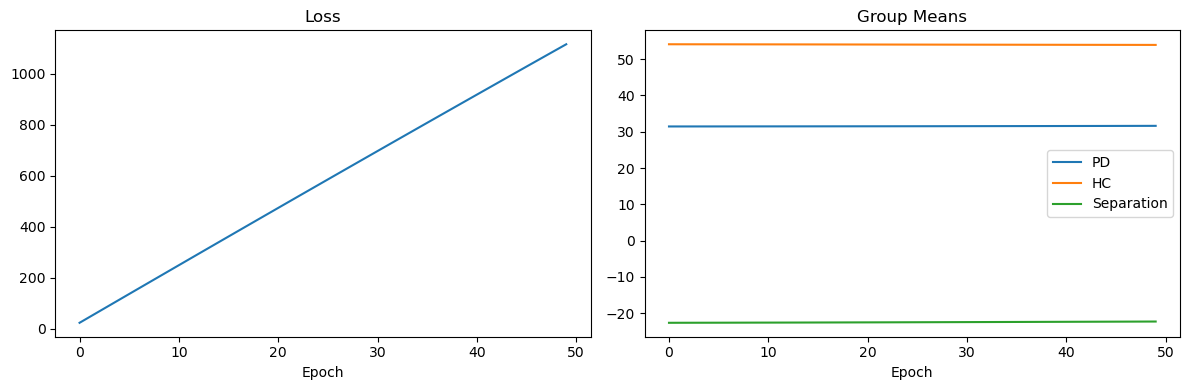

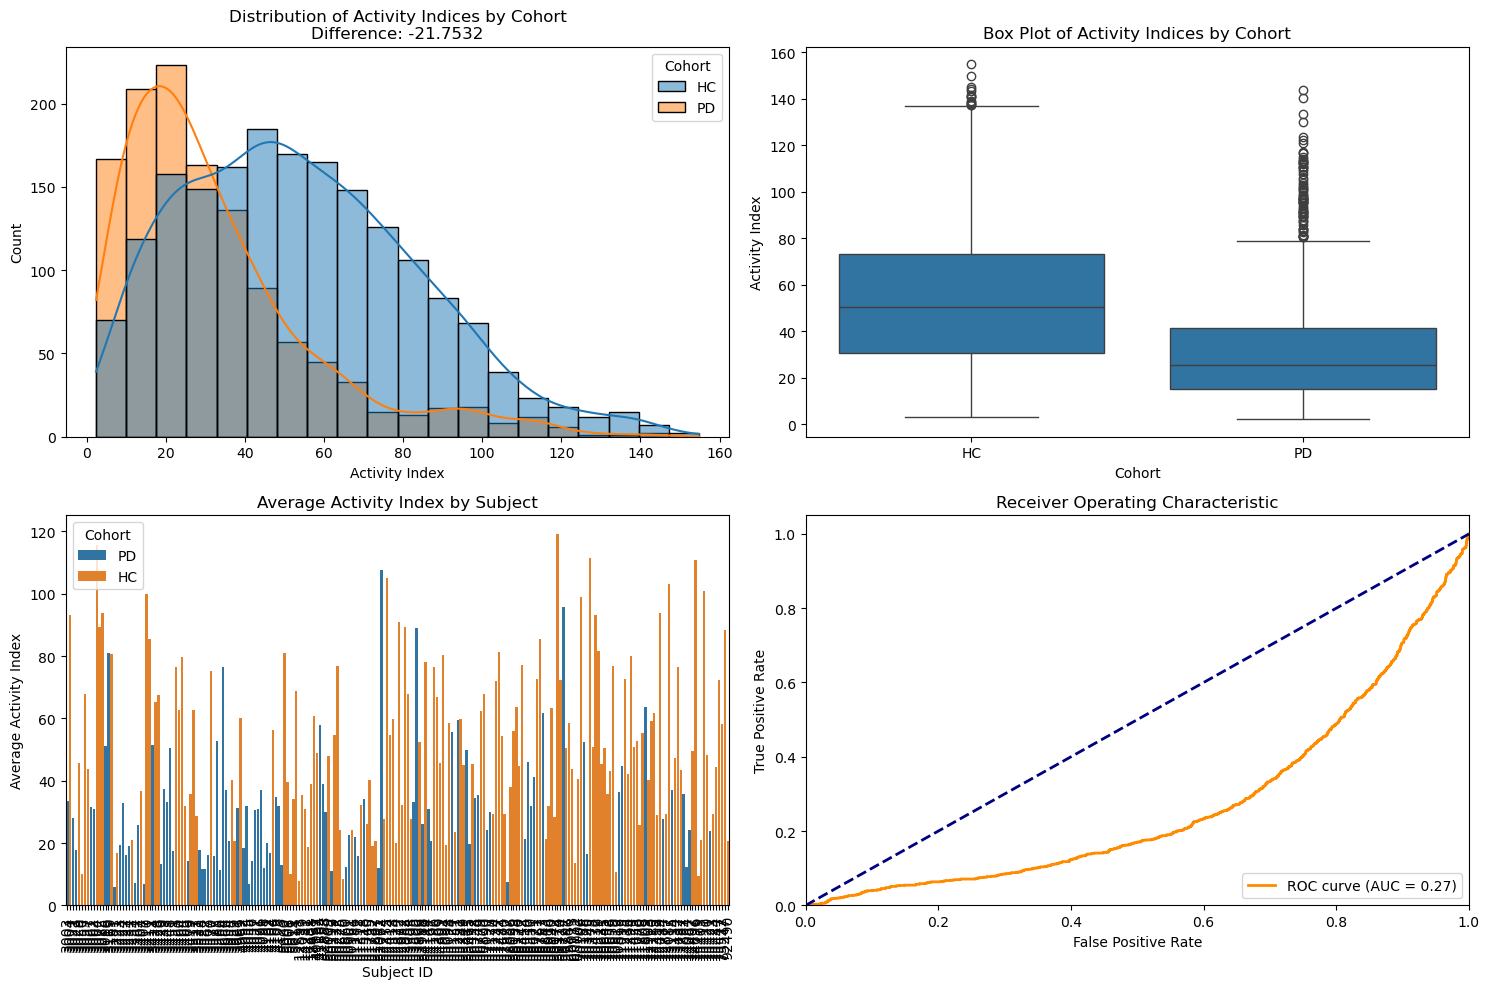

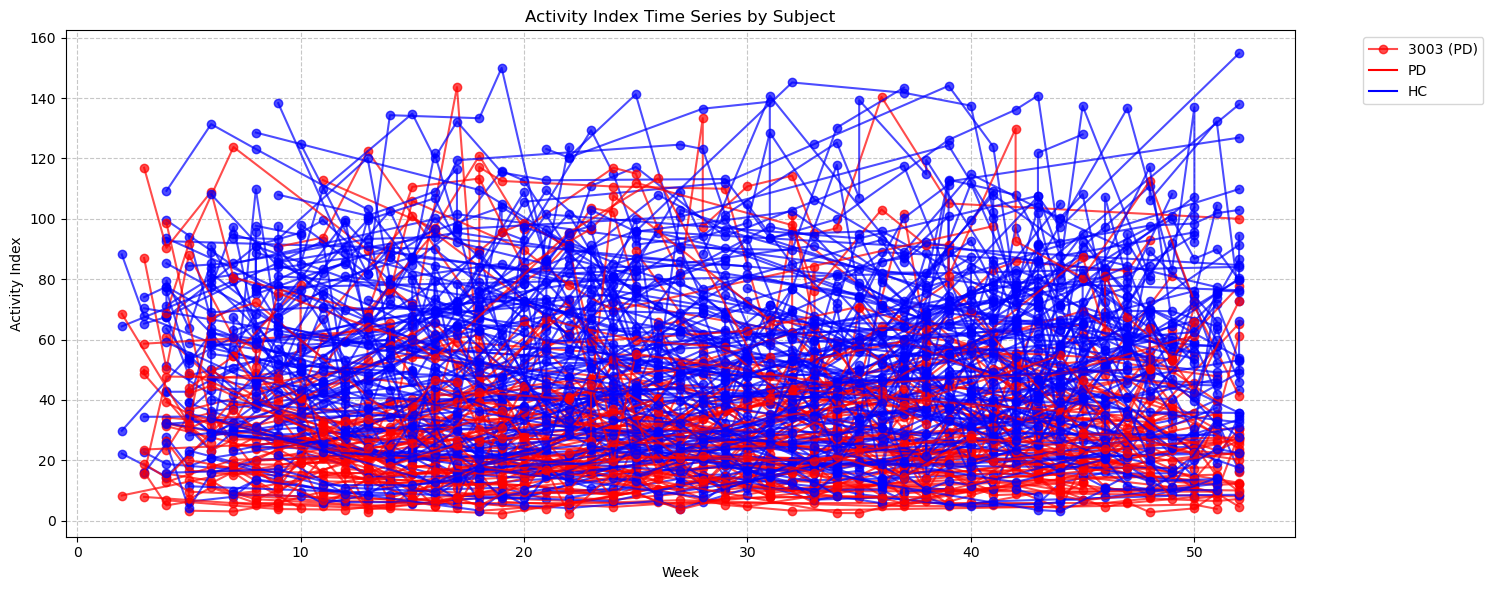

<Figure size 1000x600 with 0 Axes>

In [105]:
# get data 
sequences, current_weeks, labels, subject_weeks = prepare_sequences(df1, sequence_length=3)

# split data into train and test sets
from sklearn.model_selection import train_test_split
# create indices for splitting 
indices = np.arange(len(sequences))
train_incides, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# create train and test sets
train_sequences = sequences[train_incides]
test_sequences = sequences[test_indices]
train_labels = labels[train_incides]
test_labels = labels[test_indices]
train_subject_weeks = [subject_weeks[i] for i in train_incides]
test_subject_weeks = [subject_weeks[i] for i in test_indices]
train_current_weeks = current_weeks[train_incides]
test_current_weeks = current_weeks[test_indices]

# create model
model = ActivityLSTM(input_dim=7, hidden_dim=16, num_layers=1)
# train model
trained_model, loss_history = train_model(
    model, 
    train_sequences, 
    train_current_weeks,
    train_labels, 
    train_subject_weeks,
    num_epochs=50
)

# evaluate model
evaluate_and_plot(
    trained_model, 
    test_sequences, 
    test_current_weeks, 
    test_labels, 
    test_subject_weeks
)